In [1]:
from utils import load_series_dfs
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os
from shapely import wkt, Point
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pickle
import requests
from utils import load_series_dfs
from config.weather_params import WeatherParam
from datetime import datetime

In [2]:
gpkg_path = os.path.join('..', 'data', 'df_mapping_centroids.gpkg')
df_mapping = gpd.read_file(gpkg_path)

df_mapping.columns

Index(['nemesys_key', 'geom_g', 'centroid_lon', 'centroid_lat', 'geometry'], dtype='object')

In [3]:
# 1. Resource-ID für stündliche Klimastationen
resource_id = 'klima-v1-10min'

# 2. Metadata-Endpoint ansprechen
url_meta  = f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}/metadata"
resp_meta = requests.get(url_meta)
resp_meta.raise_for_status()

# 3. Liste der Station-Dicts rausziehen
data = resp_meta.json()          # {'stations': [ {...}, {...}, … ]}
stations_list = data['stations']

# 4. In DataFrame umwandeln
stations_df = pd.DataFrame.from_records(stations_list)

# 5. Wichtige Spalten anzeigen
print("Spalten:", stations_df.columns.tolist())
print(stations_df[['id','name','lat','lon']].head())

Spalten: ['type', 'id', 'group_id', 'name', 'state', 'lat', 'lon', 'altitude', 'valid_from', 'valid_to', 'has_sunshine', 'has_global_radiation', 'is_active']
      id                           name        lat        lon
0   5882                GUMPOLDSKIRCHEN  48.035831  16.280834
1  13401            KAPFENBERG-FLUGFELD  47.458332  15.335556
2   2117             HORN -  WASSERWERK  48.674999  15.643888
3  16906                       GASCHURN  46.980278  10.031667
4  20209  KLAGENFURT/HTL1-LASTENSTRASSE  46.619446  14.316667


In [4]:
# Geometriedaten parsen und als GeoSeries setzen
df_mapping['geom_g'] = gpd.GeoSeries.from_wkt(df_mapping['geom_g'])

In [5]:
df_mapping = df_mapping.set_geometry('geom_g')

In [6]:
def interior_point(g):
    t = g.geom_type
    if t in ("Polygon", "MultiPolygon"):
        return g.representative_point()
    elif t in ("LineString", "MultiLineString"):
        return g.interpolate(0.5, normalized=True)
    elif t == "Point":
        return g
    else:
        return g.centroid

df_mapping['pt_interior'] = df_mapping['geom_g'].apply(interior_point)

In [7]:
# Quell-CRS richtig setzen
df_mapping = df_mapping.set_crs("EPSG:32633", allow_override=True)

# In Lon/Lat transformieren
df_wgs = df_mapping.to_crs(epsg=4326)

# Lon/Lat aus dem Innen-Punkt extrahieren
df_wgs['centroid_lon'] = df_wgs['pt_interior'].x
df_wgs['centroid_lat'] = df_wgs['pt_interior'].y

In [8]:
df_wgs[['centroid_lon', 'centroid_lat']]

,centroid_lon,centroid_lat
0,574298.473492,5.236470e+06
1,592254.428411,5.234861e+06
2,451102.757675,5.278928e+06
3,459558.991970,5.339463e+06
4,456008.641067,5.342558e+06
5,438565.004915,5.351961e+06
6,484911.136354,5.181469e+06
7,454988.377977,5.327099e+06
8,178961.587808,5.264391e+06
9,626005.942156,5.302132e+06


In [10]:
# 1. Für alle weiteren Schritte sicherstellen, dass df_mapping das richtige CRS hat
#    (falls noch nicht geschehen)
df_mapping = df_mapping.set_crs("EPSG:32633", allow_override=True)

# 2. Neue GeoDataFrame anlegen, wobei 'pt_interior' die aktive Geometrie wird
df_pts = gpd.GeoDataFrame(
    df_mapping.drop(columns='geometry'),  # alte geometry-Spalte entfernen, falls gewünscht
    geometry=df_mapping['pt_interior'],
    crs="EPSG:32633"
)

# 3. Jetzt transformierst Du df_pts in WGS84
df_pts = df_pts.to_crs(epsg=4326)

# 4. Longitude / Latitude aus der neuen Geometrie ziehen
df_pts['centroid_lon'] = df_pts.geometry.x
df_pts['centroid_lat'] = df_pts.geometry.y

# 5. Kontrolle
print(df_pts[['nemesys_key','centroid_lon','centroid_lat']].head())

   nemesys_key  centroid_lon  centroid_lat
0  FL_00025241     15.982384     47.277499
1  FL_00352191     16.219418     47.260741
2  FL_00020896     14.348744     47.661897
3  FL_00024730     14.455680     48.207108
4  FL_00024735     14.407575     48.234712


In [12]:
import numpy as np
from sklearn.neighbors import BallTree
import pandas as pd

# 1. Stations-Koordinaten in Radianten
coords_stat = np.deg2rad(stations_df[['lat','lon']].values)

# 2. Centroid-Interior-Koordinaten in Radianten
coords_map  = np.deg2rad(df_pts[['centroid_lat','centroid_lon']].values)

# 3. BallTree mit Haversine-Metrik bauen
tree = BallTree(coords_stat, metric='haversine')

# 4. Für jeden Centroid den nächsten Nachbarn suchen
dist_rad, idx = tree.query(coords_map, k=1)

# 5. In Kilometern umrechnen
dist_km = dist_rad.flatten() * 6371.0

# 6. Ergebnis-Tabelle zusammenbauen
result = pd.DataFrame({
    'nemesys_key':  df_pts['nemesys_key'].values,
    'stat_id':      stations_df.iloc[idx.flatten()]['id'].values,
    'stat_name':    stations_df.iloc[idx.flatten()]['name'].values,
    'dist_km':      dist_km
})

print(result.head())

   nemesys_key stat_id    stat_name    dist_km
0  FL_00025241   13605     HARTBERG   0.443336
1  FL_00352191   16711  WOERTERBERG  10.034548
2  FL_00020896    9911  HALL/ADMONT  13.024435
3  FL_00024730    5130         ENNS   1.315882
4  FL_00024735    5130         ENNS   5.357055


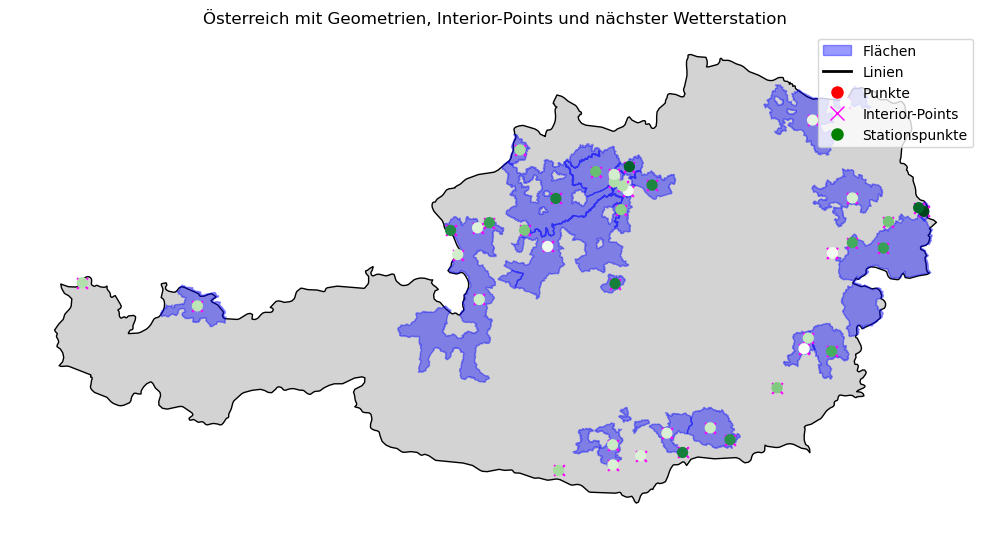

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1. GeoDataFrame aufbauen (EPSG:32633), direkt aus geom_g
gdf = gpd.GeoDataFrame(
    df_mapping,
    geometry='geom_g',
    crs='EPSG:32633'
)

# 2. Interior-Point berechnen
gdf['pt_interior'] = gdf.geometry.apply(
    lambda geom: (
        geom.representative_point() if geom.geom_type in ("Polygon","MultiPolygon")
        else geom.interpolate(0.5, normalized=True) if geom.geom_type in ("LineString","MultiLineString")
        else geom
    )
)

# 3. Österreich-Grenze via URL laden
countries_url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
world        = gpd.read_file(countries_url)
austria      = world[world['name']=='Austria'].to_crs(gdf.crs)

# 4. Stations-GeoDataFrame erstellen und transformieren
stations_gdf = (
    gpd.GeoDataFrame(
        stations_df,
        geometry=gpd.points_from_xy(stations_df.lon, stations_df.lat),
        crs='EPSG:4326'
    )
    .to_crs(gdf.crs)
)

# 5. Nächstgelegene Station per Spatial Join (inkl. Distanz in dist_m)
pts = gpd.GeoDataFrame(gdf, geometry='pt_interior', crs=gdf.crs)
joined = gpd.sjoin_nearest(
    pts, stations_gdf,
    how='left', distance_col='dist_m'
)

# 6. Plot-Layer splitten
polygons     = gdf[gdf.geom_type.isin(['Polygon','MultiPolygon'])]
lines        = gdf[gdf.geom_type.isin(['LineString','MultiLineString'])]
points       = gdf[gdf.geom_type=='Point']
pts_interior = pts.copy()

# 7. Plot
fig, ax = plt.subplots(figsize=(10,10))
austria.plot(ax=ax, color='lightgray', edgecolor='black', zorder=0)

polygons.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha=0.4, zorder=1)
lines   .plot(ax=ax, color='black', linewidth=2,       zorder=2)
points  .plot(ax=ax, color='red',   markersize=20,     zorder=3)

pts_interior.plot(
    ax=ax,
    color='magenta',
    marker='x',
    markersize=60,
    zorder=4,
    label='Interior-Points'
)

joined.plot(
    ax=ax,
    column='dist_m',         # optional: farblich nach Distanz
    cmap='Greens',           # oder einfach feste Farbe
    marker='o',
    markersize=50,
    zorder=5,
    label='Nächstgelegene Wetterstation'
)

# 8. Legende
legend_elems = [
    Patch(facecolor='blue',   edgecolor='blue',  alpha=0.4, label='Flächen'),
    Line2D([0],[0], color='black', lw=2,   label='Linien'),
    Line2D([0],[0], marker='o', color='red',   linestyle='', markersize=8,  label='Punkte'),
    Line2D([0],[0], marker='x', color='magenta', linestyle='', markersize=10, label='Interior-Points'),
    Line2D([0],[0], marker='o', color='green',   linestyle='', markersize=8,  label='Stationspunkte'),
]
ax.legend(handles=legend_elems, loc='upper right')

ax.set_title("Österreich mit Geometrien, Interior-Points und nächster Wetterstation")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johannes.misensky\Documents\KI_Master\data")

In [15]:
weather_params = WeatherParam.keys()
start_iso = '2014-01-01T06:00:00Z'
end_iso   = '2018-12-31T23:00:00Z'

# Optional: falls ein API-Token benötigt wird, hier einfügen:
# headers = {'Authorization': 'Bearer YOUR_TOKEN_HERE'}
headers = {}

# 1. Ergebnis-DF: map nemesys_key -> stat_id
#    Erwartet result DataFrame mit Spalten ['nemesys_key','stat_id']
stat_map = result.set_index('nemesys_key')['stat_id'].to_dict()

In [36]:
import requests
import pandas as pd

# 1. Dataset und Parameter definieren
resource_id   = 'klima-v1-10min'
station_id    = 13605
weather_params = ['FFAM', 'GSX', 'RF', 'RR', 'SH', 'SO', 'TB1', 'TB2', 'TL']
start_iso     = '2014-01-01T00:00'
end_iso       = '2018-01-31T23:00'

# 2. URL zusammenbauen (Kommas UNESCAPED!)
param_str = ','.join(weather_params)
url = (
    f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}"
    f"?station_ids={station_id}"
    f"&parameters={param_str}"
    f"&start={start_iso}"
    f"&end={end_iso}"
    f"&format=json"
)
print(url)
# 3. Anfrage und Fehlercheck
resp = requests.get(url)
resp.raise_for_status()
fc = resp.json()

# 4. Zeiten und Feature-Daten extrahieren
timestamps = pd.to_datetime(fc['timestamps'])      # alle Zeitpunkte
feat       = fc['features'][0]                     # nur eine Station
params     = feat['properties']['parameters']      # dict mit Param.-Daten

# 5. DataFrame aufbauen
df_weather = pd.DataFrame(
    {p: params[p]['data'] for p in weather_params if p in params},
    index=timestamps
)

# 6. Ergebnis inspizieren
print(df_weather.head())



https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v1-10min?station_ids=13605&parameters=FFAM,GSX,RF,RR,SH,SO,TB1,TB2,TL&start=2014-01-01T00:00&end=2018-01-31T23:00&format=json


HTTPError: 400 Client Error: Bad Request for url: https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v1-10min?station_ids=13605&parameters=FFAM,GSX,RF,RR,SH,SO,TB1,TB2,TL&start=2014-01-01T00:00&end=2018-01-31T23:00&format=json

In [32]:
import requests
import pandas as pd

# 1. Basis-Settings
resource_id    = 'klima-v1-10min'
weather_params = ['FFAM','GSX','RF','RR','SH','SO','TB1','TB2','TL']
start_iso      = '2014-01-01T06:00'
end_iso        = '2018-12-31T23:00'

# 2. Ergebnis-Container
summary = []

# 3. Durch alle Stationen iterieren
for stat_id in result['stat_id'].unique():

    url = (
    f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}"
    f"?station_ids={stat_id}"
    f"&parameters={param_str}"
    f"&start={start_iso}"
    f"&end={end_iso}"
    f"&format=json"
    )
    print(url)
    resp = requests.get(url)
    resp.raise_for_status()

    fc = resp.json()
    timestamps = fc.get('timestamps', [])
    features   = fc.get('features', [])

    # b) Keine Daten zurück?
    if not timestamps or not features:
        summary.append({
            'station_id': stat_id,
            'status':   'no_data',
            'records':  0,
            'missing_params': weather_params.copy()
        })
        continue

    # c) Welche Parameter werden geliefert?
    props      = features[0]['properties']['parameters']
    avail_keys = set(props.keys())
    missing    = [p for p in weather_params if p not in avail_keys]

    summary.append({
        'station_id':     stat_id,
        'status':         'ok',
        'records':        len(timestamps),
        'missing_params': missing
    })

# 4. Zusammenfassung als DataFrame
df_summary = pd.DataFrame(summary)

# 5. Ausgabe
print(df_summary)



https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v1-10min?station_ids=13605&parameters=FFAM,GSX,RF,RR,SH,SO,TB1,TB2,TL&start=2014-01-01T06:00&end=2018-12-31T23:00&format=json


HTTPError: 400 Client Error: Bad Request for url: https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v1-10min?station_ids=13605&parameters=FFAM,GSX,RF,RR,SH,SO,TB1,TB2,TL&start=2014-01-01T06:00&end=2018-12-31T23:00&format=json